In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import os
import sys

src_path = os.path.abspath(os.path.join(os.getcwd(),  '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from data_preprocess import DataCleaner


In [2]:
df = pd.read_excel(r'../data/raw/Incapacidades_Empresa.xlsx')
cleaner = DataCleaner(df)
df = cleaner.limpiar()
df.head()

,c.c_colaborador,eps,ips,arl,fondo_de_pensiones,salario_colaborador,incapacidad_dias,incapacidad_fecha_de_inicio,incapacidad_diagnóstico,clasificación_incapacidad,...,alerta_empleado_en_periodo_de_carencia,alerta_ter_inconsistente,fecha_fin_incapacidad,costo_total_incapacidad,incapacidades_acumuladas_por_colaborador,dias_acumulados_por_colaborador,dias_promedio_por_incapacidad_colaborador,mes,año,incapacidades_por_mes
0,1,COMFENALCO VALLE,IPS RIO CAUCA SQ,ARL SURA,PORVENIR,160000.0,1,2022-01-02,A09X,NO,...,1,1,2022-01-03,5333.333333,3,4,1.333333,1.0,2022.0,135.0
1,2,SURA,IPS COLSUBSIDIO NUESTRO BOGOTA,ARL SURA,PROTECCION,672000.0,2,2022-01-02,J039,NO,...,1,0,2022-01-04,44800.000000,3,5,1.666667,1.0,2022.0,135.0
2,3,MUTUAL SER,CONGREGACION DE HNAS FRANCISCANAS,ARL SURA,PORVENIR,423500.0,5,2022-01-03,S934,NO,...,0,1,2022-01-08,70583.333333,6,23,3.833333,1.0,2022.0,135.0
3,4,COOSALUD,MAURO MIGUEL RIVERA,ARL SURA,PROTECCION,160000.0,15,2022-01-05,Z359,SI,...,0,0,2022-01-20,80000.000000,2,141,70.500000,1.0,2022.0,135.0
4,5,SURA,MASMEDICAL,ARL SURA,COLPENSIONES,160000.0,1,2022-01-03,T07X,NO,...,1,0,2022-01-04,5333.333333,2,31,15.500000,1.0,2022.0,135.0


In [3]:
df['alerta_certificado_invalido'].value_counts()

alerta_certificado_invalido
0    2817
1    2763
Name: count, dtype: int64

In [4]:
df[['c.c_colaborador','alerta_certificado_invalido']]

,c.c_colaborador,alerta_certificado_invalido
0,1,1
1,2,1
2,3,0
3,4,1
4,5,0
...,...,...
5575,1817,1
5576,543,1
5577,1727,1
5578,1818,1


In [5]:
# Columnas que generan fuga o no deben usarse
cols_to_drop = [
    'alerta_número_de_certificado_repetido',
    'alerta_posible_prórroga',
    'alerta_posible_accidente_de_trabajo',
    'alerta_empleado_en_periodo_de_carencia',
    'alerta_ter_inconsistente',
    "incapacidad_fecha_de_inicio",
    "fecha_fin_incapacidad"
]

# Limpiar y seleccionar
df = df.drop(columns=cols_to_drop, errors='ignore')
df = df.dropna(subset=['alerta_certificado_invalido'])

X = df.drop(columns=['c.c_colaborador', 'alerta_certificado_invalido'])
y = df['alerta_certificado_invalido'].astype(int)  # Asegura binaria

print(f"🔹 X shape: {X.shape}")
print(f"🔹 y shape: {y.shape}")

🔹 X shape: (5580, 17)
🔹 y shape: (5580,)


In [6]:
X.dtypes

eps                                           object
ips                                           object
arl                                           object
fondo_de_pensiones                            object
salario_colaborador                          float64
incapacidad_dias                               int64
incapacidad_diagnóstico                       object
clasificación_incapacidad                     object
incapacidad_origen                            object
incapacidad_tipo_de_generación                object
costo_total_incapacidad                      float64
incapacidades_acumuladas_por_colaborador       int64
dias_acumulados_por_colaborador                int64
dias_promedio_por_incapacidad_colaborador    float64
mes                                          float64
año                                          float64
incapacidades_por_mes                        float64
dtype: object

In [7]:
# Detectar tipos de variables
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Asegurar que todas las columnas categóricas sean string
X[categorical_features] = X[categorical_features].astype(str)

# Pipeline para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Aplicar transformaciones
X_preprocessed = preprocessor.fit_transform(X)

# Obtener nombres de columnas transformadas
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(onehot_feature_names)

# Convertir a DataFrame
X_preprocessed_df = pd.DataFrame(
    X_preprocessed.toarray() if hasattr(X_preprocessed, "toarray") else X_preprocessed,
    columns=all_feature_names,
    index=X.index
)

X_preprocessed_df.head()


,salario_colaborador,incapacidad_dias,costo_total_incapacidad,incapacidades_acumuladas_por_colaborador,dias_acumulados_por_colaborador,dias_promedio_por_incapacidad_colaborador,mes,año,incapacidades_por_mes,eps_ALIANSALUD,...,incapacidad_tipo_de_generación_VAGINITIS SUBAGUDA Y CRONICA,"incapacidad_tipo_de_generación_VAGINITIS, VULVITIS Y VULVOVAGINITIS EN ENFERMEDADES INFECCIOSAS Y PARASITARIAS CLASIFICADAS EN OTRA PARTE",incapacidad_tipo_de_generación_VARICELA SIN COMPLICACIONES,incapacidad_tipo_de_generación_VARICES EN OTROS SITIOS ESPECIFICADOS,incapacidad_tipo_de_generación_VARICES ESCROTALES,incapacidad_tipo_de_generación_VENAS VARICOSAS DE LOS MIEMBROS INFERIORES CON ULCERA,incapacidad_tipo_de_generación_VENAS VARICOSAS DE LOS MIEMBROS INFERIORES CON ULCERA E INFLAMACION,incapacidad_tipo_de_generación_VENAS VARICOSAS DE LOS MIEMBROS INFERIORES SIN ULCERA NI INFLAMACION,incapacidad_tipo_de_generación_VERTIGO PAROXISTICO BENIGNO,incapacidad_tipo_de_generación_VIOLENCIA FISICA
0,-0.825765,-0.443551,-0.425542,-0.514100,-0.483165,-0.617031,-1.452835,-1.031691,-2.290788,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.219658,-0.351313,-0.176961,-0.514100,-0.476787,-0.571074,-1.452835,-1.031691,-2.290788,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.226909,-0.074600,-0.014564,-0.288693,-0.361988,-0.272355,-1.452835,-1.031691,-2.290788,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.825765,0.847777,0.044747,-0.589235,0.390585,8.918988,-1.452835,-1.031691,-2.290788,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.825765,-0.443551,-0.425542,-0.589235,-0.310966,1.336130,-1.452835,-1.031691,-2.290788,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# ==================================
# 3. Eliminar colinealidad (> 0.9)
# ==================================
corr_matrix = X_preprocessed_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

correlation_threshold = 0.9
high_corr_cols = [col for col in upper_tri.columns if any(upper_tri[col] > correlation_threshold)]

print(f"📌 Variables eliminadas por colinealidad: {len(high_corr_cols)}")
X_nocolineal = X_preprocessed_df.drop(columns=high_corr_cols)

print(f"✅ Shape después de quitar colinealidad: {X_nocolineal.shape}")

📌 Variables eliminadas por colinealidad: 840
✅ Shape después de quitar colinealidad: (5580, 1684)


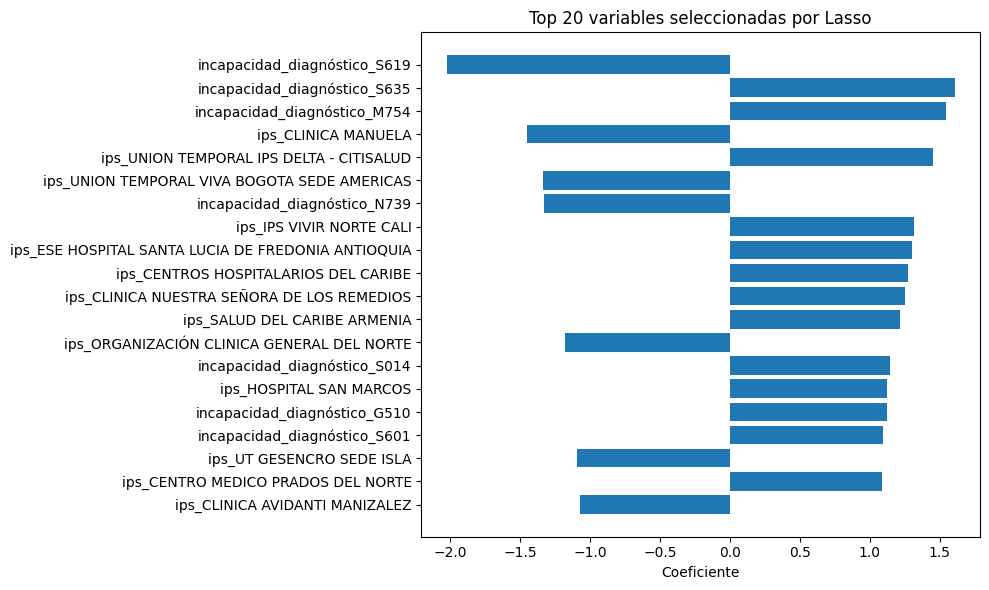

In [9]:
# ==========================================
# 5. Exportar ranking de variables Lasso
# ==========================================
lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    random_state=42,
    max_iter=1000,
    C=1.0,
)
lasso_model.fit(X_nocolineal, y)

coef_df = pd.DataFrame({
    'feature': X_nocolineal.columns,
    'coefficient': lasso_model.coef_[0]
})
coef_df = coef_df[coef_df['coefficient'] != 0]
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['feature'].iloc[:20], coef_df['coefficient'].iloc[:20])
plt.xlabel('Coeficiente')
plt.title('Top 20 variables seleccionadas por Lasso')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Exportar ranking
os.makedirs('../data/procesed', exist_ok=True)
coef_df[['feature']].to_csv('../data/processed/features.csv', index=False)